# Project 3: Where's Waldo?

Due Mar. 4th

So far, we've mostly focused on using imagery to do stuff for which it is better suited than a human: calculating camera locations from imagery, finding an optimal projective transform to stitch images together, and (soon) we'll be doing "structure from motion" in which we create 3D models of the world from collections of 2D images.  These are tasks primarily based around measuring things and doing calculations.  On the other side of the coin is object recognition (identifying the semantic content of a scene), and the best contemporary computer vision algorithms do object recognition at roughly the level of a 2 year old human (with some exceptions).  For this (mini-)project, we're going to delve into a topic that sort of straddles the line between these two general realms of computer vision.

As a motivating example, did you ever play the game Where's Waldo.  There are books filled with images like the following:
<img src='waldo_1.jpg'>
The objective, of course, is to find Waldo, the man in the red striped shirt and beanie wearing glasses.  He looks like this:
<img src='waldo_template.jpg'>
These scenes are (obviously) intended to have a bunch of visual clutter to make this task reasonably challenging.

Your task will be to come up with an algorithm that locates the template image (Waldo's face) and the target image (the larger scene).  This is called *template matching*, and it's a primitive form of feature recognition.  

## Implementation
### Template Matching
Template matching works in a way that is very similar to filtering:  slide the template image over every location in the target image, computing some sort of metric at each position.  In practice, one commonly used choice for an error metric is the one that you've already used for matching keypoint descriptors: z-normalized sum square error.  Another choice is [normalized cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Normalization).  Once these metrics have been computed, simply find the argmin (for SSE) or argmax (for NCC), and this will be the location of the best match.  

**Your task is to implement template matching.  Use 'waldo_template.jpg' as the template and 'waldo_1.jpg' as the target image.  Where's Waldo? **

### Not so fast!!!  What about scale!
Oh, no.  As it turns out, the template I've provided is not the same scale as the Waldo in the image.  To deal with this, you'll need to create an image pyramid for the template (See Szeliski 3.5, and [Mubarak Shah's lecture on this topic](https://www.youtube.com/watch?v=KO7jJt0WHag&feature=youtu.be)).  This essentially just means creating a sequence of downsampled images of the template, and trying each one in hopes that one of the resulting down-scaled templates matches the feature in the target image.  **Create a sequence of templates with which to perform feature matching, each one 1/2 the resolution of the previous (so 1/4 the total number of pixels).  To avoid aliasing, before downsampling perform a $\sigma=1$ Gaussian Blur of the image.  Once you've built your image pyramid, find the argmin/max in 3 dimensions (u,v,template scale)**.

## Generalization
**Waldo appears in every Where's Waldo image (obviously).  Try using the same technique on 'waldo_2.jpg'.  Does the algorithm work?**  I confess that I pulled the image of waldo for the template directly from 'waldo_1.jpg', so for the correct scale, there is something close to an exact match (i.e. SSE=0).  However, Waldo, while easily recognizable to the human eye after undergoing the small scale deformations associated with artistic license, is not so easily recognizable via template matching.  We will return to a similar problem when discussing object recognition, and hopefully this example will motivate the need to come up with representations of objects (like Waldo) that are more robust.


###### Brian Stampe

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import importlib
#from functions import convolve,Harris,pull_local_maxima
#moduleName = input('functions.py')
import functions
importlib.reload(functions);

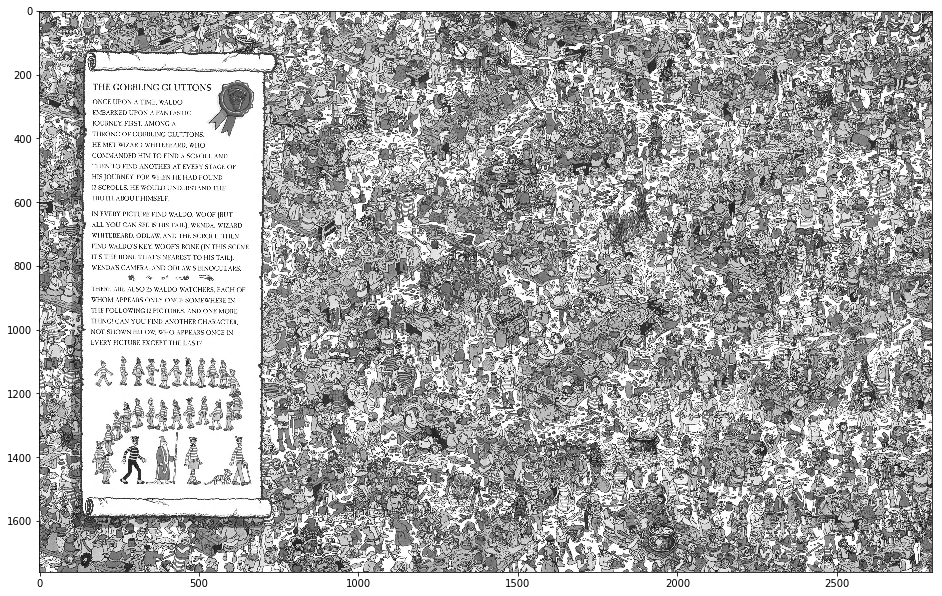

In [66]:
Ic = plt.imread('waldo_1.jpg')
wc = plt.imread('waldo_template.jpg')
I = Ic.mean(axis=2)


w = wc.mean(axis=2)
plt.figure(figsize=(16,16))
# Im not sure why I have to make image and template negative... somehow values are getting flipped
plt.imshow(I, cmap='gray');

In [17]:
# must downsample template to match size of waldo in wheres waldo image

def convolve_downsample(g,h="gaussian",m=3,n=3, sigma=1):
    '''
    input image as g, kernal as h, m gives columns as well as guassian size
    n gives number of rows, sigma gives standard deviation for gaussian
    can also supply your own kernal = provide a 2-D numpy array to do an element wise
    multiplication on image. Now skip every other pixel to 'downsample'.
    '''
    I_height, I_width = g.shape[0], g.shape[1]  # now half as big 
    image = np.zeros((g.shape[0],g.shape[1])) # prevents altering in place # new image to alter
    

    if h == 'gaussian':
        '''
        use seperable filter property of the gaussian to speed up computation
        first run a 1-d in horizantal, then on resulting image, run in vertical
        This is a special property of the gaussian kernal and in general may not be used
        in other nonlinear kernals.
        
        '''
        print ('performing gaussian convolution downsampling')
        sigma = sigma
        m = m
        h = np.ones(m)
        center = (m-1)/2 

        for i in range(len(h)):
            exponent = -((i-center)**2)/(2*sigma**2)
            h[i] = np.exp(exponent)
            
        h /= h.sum()
        
        border_height =  np.int((len(h) - 1)/2)
        border_width =  np.int((len(h) - 1)/2)
        
        
        # run 1-D gaussian kernal in horizontal
        for u in range(border_width,int(I_width-border_width)):
            for v in range(border_height, int(I_height - border_height)):
                image[v,u] = (h*g[v-border_height:v+border_height+1,
                                        u-border_width:u+border_width+1]).sum()
                
        # now run a 1-D gaussian in the vertical on already convolved image
        for u in range(border_width,int(I_width-border_width)):
            for v in range(border_height, int(I_height - border_height)):
                image[v,u] = (h.T*g[v-border_height:v+border_height+1,
                                        u-border_width:u+border_width+1]).sum()
    
    else:
        
        if h == "box":
            m,n = m,n
            h = np.ones([n,m])/(m+n)
            print ("box")

        border_height =  np.int((h.shape[0] - 1)/2)
        border_width =  np.int((h.shape[1] - 1)/2)
        
        for u in range(border_width,int(I_width-border_width)):
            for v in range(border_height, I_height - border_height):
                image[v,u] = (h*g[v-border_height:v+border_height+1,
                                            u-border_width:u+border_width+1]).sum()       

            
    return image, image[::2,::2] # take every other pixel

# here i was downsampling the Image, but later I realized to downsample the template. 

#_, image2 = convolve_downsample(I,h="gaussian")

In [ ]:
#image3 = convolve_downsample(image2, h="gaussian")

In [ ]:
# downsampling image not what we want, he must have upsampled the template from the image
#plt.imshow(image3,cmap='Greys');

In [20]:
# downsample the template and store
_, w2 = convolve_downsample(w, h='gaussian')
_, w3 = convolve_downsample(w2, h='gaussian')
_, w4 = convolve_downsample(w3, h='gaussian')

performing gaussian convolution downsampling
performing gaussian convolution downsampling
performing gaussian convolution downsampling


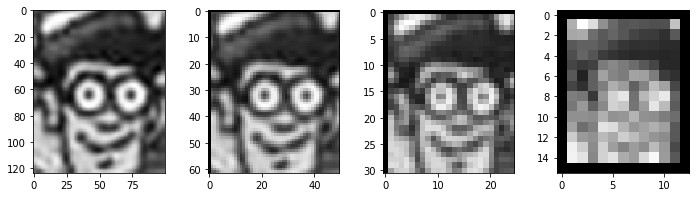

In [153]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(12,3))
ax1.imshow(w, cmap='gray')
ax2.imshow(w2, cmap='gray')
ax3.imshow(w3, cmap='gray')
ax4.imshow(w4, cmap='gray');

In [94]:
# first attempt, hadn't taken into account even or odd sized templates

def template_match(I,template):
    '''now takes a single template'''
    
    w = template
    borderu = int((w.shape[1]-1)/2)
    borderv = int((w.shape[0]-1)/2)

    I_cropped = I[borderv:int(I.shape[0])-borderv, borderu:int(I.shape[1])-borderu]
    zw = (w-w.mean())/w.std()
    error_image = np.zeros_like(I)*1e6

    for u in range(I_cropped.shape[1]-1): # x
        for v in range(I_cropped.shape[0]-1): #y
            # compute window statitsic for W and I
            patchi = I[v:v+int(w.shape[0]), u:u+int(w.shape[1])]
            zi = (patchi-patchi.mean())/patchi.std()
            SSE = (zw-zi)**2
            error_image[v+borderv,u+borderu] = np.sum(SSE) 
    
    # you could also append indices, for access to multiple minima
    # here i grab coordinates of error_image that satisfy boolean
    center = np.where(error_image == np.nanmin(error_image)) # find center with minimum value
    #center = np.where((error_image == error_image.min()))
    
    return error_image, center


In [189]:
def template_match(I,template):
    '''
    now takes a single template and returns an error image, 
    and the coordinates that contain the minima
    
    '''
    
    w = template
    
    wv, wu = w.shape[0], w.shape[1]
    if wv%2==0 and wu%2==0:
        borderv= wv//2
        borderu= wu//2
    else: # we have flooring/rounding down so that messes with iterables in double for loop
        borderv = int((wv-1)/2)
        borderu = int((wu-1)/2)
    
    Iy,Ix = I.shape
    
    
    I_cropped = I[borderv:int(Iy)-borderv, borderu:int(Ix)-borderu]
    zw = (w-w.mean())/w.std()
    error_image = np.ones_like(I)*1e6

    for u in range(borderu, Ix-borderu): # x/u columns
        for v in range(borderv, Iy-borderv): # y/v rows
            # compute window statitsic for W and I
            if wv%2==0 and wu%2==0:
                patchi = I[v-borderv:v+borderv, u-borderu:u+borderu]
            else:
                patchi = I[v-borderv:v+borderv+1, u-borderu:u+borderu+1]
            
            zi = (patchi-patchi.mean())/patchi.std()
            SSE = (zw-zi)**2
            error_image[v,u] = np.sum(SSE) 
    
    # you could also append indices, for access to multiple minima
    # here i grab coordinates of error_image that satisfy boolean
    
    #center = np.where(error_image == np.nanmin(error_image)) # find center with minimum value
    #first subtract out borders that are zero:
    center = np.where((error_image == error_image[borderv:-borderv,borderu:-borderu].min()))
    
    return error_image, center


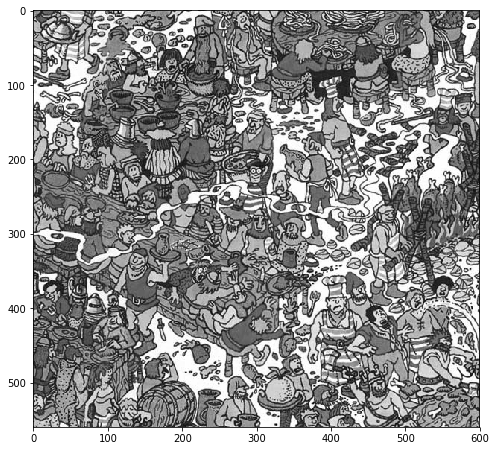

In [190]:
# got this idea from Nick
#faster debugging/running if you crop first
I_small = I[400:-800, 1300:-900]
plt.figure(figsize=(8,8))
plt.imshow(I_small, cmap='gray');

In [191]:

#error_image1, center1 = template_match(I_small,w)
error_image2, center2 = template_match(I_small,w2)
error_image3, center3 = template_match(I_small,w3)
#error_image4, center4 = template_match(I_small,w4)

In [161]:
error_image2[31:-31,25:-25]
w3.shape[0],w3.shape[1]


(31, 25)

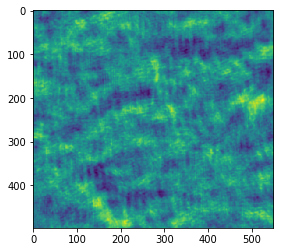

In [148]:
plt.imshow(error_image2[31:-31,25:-25]);
#plt.imshow(error_image3);

In [195]:
error_image2_sorted = np.sort(error_image2[31:-31,25:-25].flatten()) # n cropped
error_image3_sorted = np.sort(error_image3[15:-15,12:-12].flatten()) # n cropped

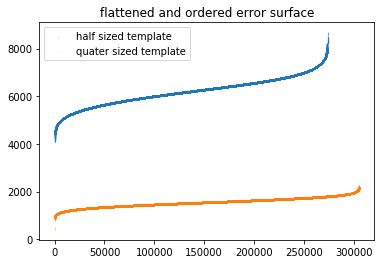

In [204]:
plt.scatter(np.arange(error_image2_sorted.size),error_image2_sorted, s=.01, label='half sized template')
plt.scatter(np.arange(error_image3_sorted.size),error_image3_sorted, s=.01, label='quater sized template')
plt.legend()
plt.title('flattened and ordered error surface');

In [220]:
e3sorted = np.sort(error_image3.flatten())
e2sorted = np.sort(error_image2.flatten())

In [226]:
# maybe its not the perfect minima, but 2nd or third or .... 
e3sorted[:10]
e2sorted[:10]

center32 = np.where(error_image3 == e3sorted[1])
center33 = np.where(error_image3 == e3sorted[2])
center34= np.where(error_image3 == e3sorted[3])
center35= np.where(error_image3 == e3sorted[4])
center36= np.where(error_image3 == e3sorted[5])
center37= np.where(error_image3 == e3sorted[6])
center38= np.where(error_image3 == e3sorted[7])

center22= np.where(error_image2 == e2sorted[1])
center23 = np.where(error_image2 == e2sorted[2])
center24 = np.where(error_image2 == e2sorted[3])
center27 = np.where(error_image2 == e2sorted[6])

In [227]:
center22

(array([121]), array([375]))

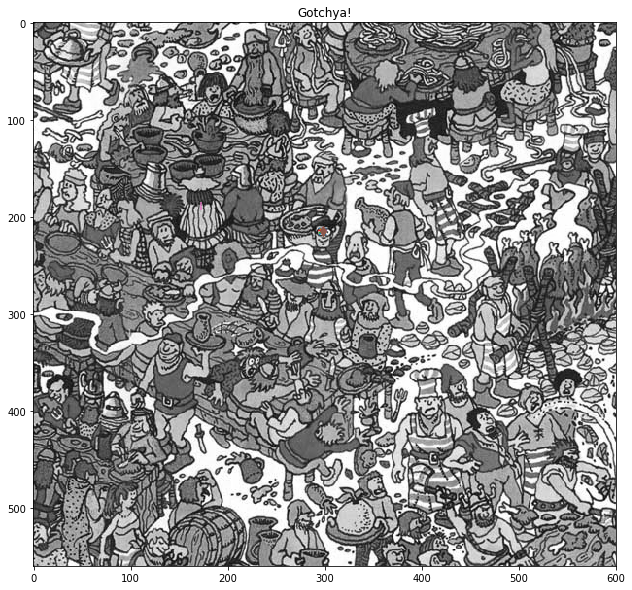

In [284]:
plt.figure(figsize=(20,10))
# full waldo
#plt.scatter(int(center1[0]), int(center1[1]), marker='.' , s=50)

# half waldo
#plt.scatter(int(center2[1]),int(center2[0]), s=50)
# 2nd or third or 4th minima....?
#plt.scatter(int(center22[1]), int(center22[0]), marker='1',s=50)
#plt.scatter(int(center23[1]), int(center23[0]), marker='2',s=50)
#plt.scatter(int(center24[1]), int(center24[0]), marker='3', s=50)
#plt.scatter(int(center27[1]), int(center27[0]), marker='4',s=50)

# quarter waldo
plt.scatter(int(center3[1]), int(center3[0]), marker='x', s=50)
# 2nd, third, or 4th minima....?
plt.scatter(int(center32[1]), int(center32[0]), marker='1', s=50)
plt.scatter(int(center33[1]), int(center33[0]), marker='2', s=50)
plt.scatter(int(center34[1]), int(center34[0]), marker='3', s=50)
plt.scatter(int(center35[1]), int(center35[0]), marker='4', s=50)
plt.scatter(int(center36[1]), int(center36[0]), marker='d', s=50)
plt.scatter(int(center37[1]), int(center37[0]), marker='|', s=50)
plt.scatter(int(center38[1]), int(center38[0]), marker= '$...$', s=50)


plt.imshow(I_small, cmap='gray')
plt.title('Gotchya!');


That took way longer than expected. I had everything right, except I had messed up my scatter plot indices... plotting y,x instead of x,y. I suppose its good to be reminded that sometimes the simplest logic errors can be the most difficult to find, as you aren't suspecting them. Atleast, I practiced my data investigating skills, by recreating Nick's errors and confirming my algorithm was working, n that it must be something located on the tailend of the pipeline. 

I left the test with Nicks code as a reminder of how much work it is if you mess something simple up. 

In [232]:

#Nick's/Nick's group's Code:
# test to see if it is my downsamplling or my template matching algorithm that is wrong
# see if I can get correct output with my downsampling and his known to work code

def dhat(patch):
    dhat = (patch - np.mean(patch))/(np.std(patch)+1.e-10)
    return dhat

def z_normal(patch1, waldo):
    error = np.sum((patch1 - waldo)**2)
    return error

def template_matching(temp, im):
    #wheres waldo image
    imy, imx = im.shape 
    
    #waldo template
    tempy, tempx = temp.shape 
    tempy_half = tempy//2
    tempx_half = tempx//2
    
    # Array to hold z-normalized errors for every pixel
    errors = np.ones((imx, imy))*1.e6
    
    
    for y in range(tempy_half, imy-tempy_half):
        for x in range(tempx_half, imx-tempx_half):
            
            if tempy%2==0 and tempx%2==0:
                im_sub = im[y-tempy_half:y+tempy_half, x-tempx_half:x+tempx_half]
            else:
                im_sub = im[y-tempy_half:y+tempy_half+1, x-tempx_half:x+tempx_half+1]
            
            im_sub_hat = dhat(im_sub)
            waldo_hat = dhat(temp)
            
            er = z_normal(im_sub_hat, waldo_hat)
            errors[x,y] = er
    
    # Get minimun coordinate
    #errors = errors[~np.isnan(errors)] #drop nans
    match = np.where(errors==errors.min())
    
    return match, errors

In [233]:
# Run Functions
match_1, er1 = template_matching(w, I_small)
match_2, er2 = template_matching(w2, I_small)
match_3, er3 = template_matching(w3, I_small)

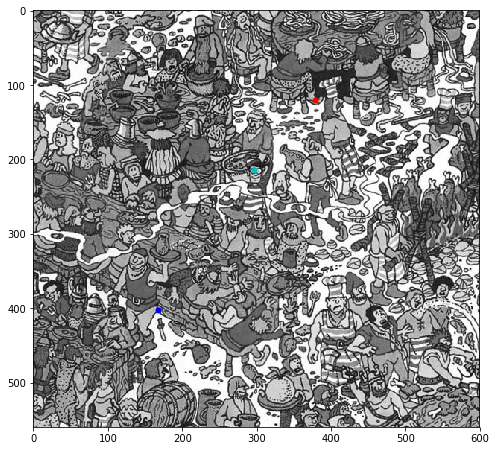

In [235]:
fig,ax=plt.subplots(nrows=1, ncols=1, figsize=(8,8))
ax.imshow(I_small,cmap='gray')
ax.plot(match_1[0], match_1[1], 'r.', markersize=10)
ax.plot(match_2[0], match_2[1], 'b.', markersize=10)
ax.plot(match_3[0], match_3[1], 'c.', markersize=10)
plt.show()

In [256]:
#plt.imshow(er1)

er2_sorted = np.sort(er2.flatten())
er3_sorted = np.sort(er3.flatten())

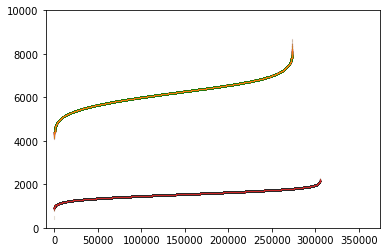

In [259]:
plt.scatter(np.arange(er2.size),er2_sorted, s=.001) # nicks error
plt.scatter(np.arange(error_image2_sorted.size),error_image2_sorted, s=.001) # my error

plt.scatter(np.arange(er3.size),er3_sorted, s=.001) # nicks error
plt.scatter(np.arange(error_image3_sorted.size),error_image3_sorted, s=.001) # my error

plt.ylim(0,10000)
plt.xlim(-10000,375000);

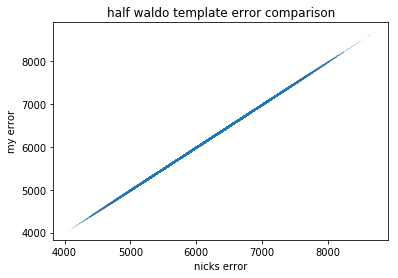

In [268]:
plt.scatter(er2_sorted[:error_image2_sorted.size], error_image2_sorted, s=.001)
plt.ylabel('my error')
plt.xlabel('nicks error')
plt.title('half waldo template error comparison');

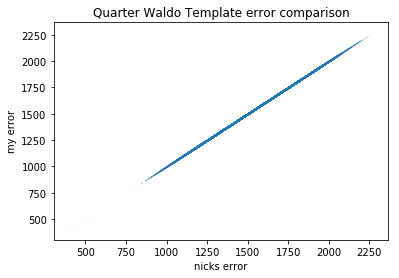

In [267]:
plt.scatter(er3_sorted[:error_image3_sorted.size], error_image3_sorted, s=.001)
plt.ylabel('my error')
plt.xlabel('nicks error')
plt.title('Quarter Waldo Template error comparison');

In [272]:

er3_sorted[10], error_image3_sorted[10] # almost exactly the same, one slight deviation at decimal ~10
# shows that they should be giving the same answer, and that I didn't accidently copy one to the other. 
# So I must not be returning the right indices...F?UCK@ That is annoying

(841.2265319029345, 841.2265319041867)

In [270]:
from scipy.stats.stats import pearsonr

pearsonr(er3_sorted[:error_image3_sorted.size],error_image3_sorted)

(1.0, 0.0)

(560, 600)